<a href="https://colab.research.google.com/github/szulcmaciej/colab-notebooks/blob/main/ChallengING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, loading data, basic preprocessing

In [ ]:
!pip install --upgrade tensorflow-gpu
!pip install --upgrade pandas

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 30.2MB/s 
     |████████████████████████████████| 450kB 39.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.2)


In [ ]:
import tensorflow as tf
import pandas as pd
print(tf.__version__)
print(pd.__version__)

2.0.0
0.25.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# models, evaluation
from sklearn import tree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from collections import Counter
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
import sklearn
from sklearn import svm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/dane/ChallengING2019/'

transactions_df = pd.read_parquet(path + 'transactions.parquet').drop(columns=['Unnamed: 0'])
clients_df = pd.read_csv(path + 'clients.csv')
transaction_types_df = pd.read_csv(path + 'transactions_type.csv')
clients_test_df = pd.read_csv(path + 'clients_test.csv')
currencies_df = pd.read_csv(path + 'currencies.csv')


In [ ]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'], format='%Y%m%d')

transactions_df = transactions_df.merge(transaction_types_df, left_on='prod_trans_type_id', right_on='pk_prod_trans_type_id')

# Basic analysis

In [ ]:
clients_df.count()

cst_id                17737
is_individual_flag    17737
main_id               17737
city                  17737
region                17737
dtype: int64

In [ ]:
transactions_df.groupby(['trans_category', 'trans_type']).count().reset_index().pivot_table(
    values='credit_amt_curr', index='trans_category', columns='trans_type', aggfunc='sum', fill_value=0, dropna=False).reset_index().sort_values(by='trans_category')

trans_type,trans_category,CASH,NONCASH
0,ATM,411407,0
1,BLIK-mobile,0,19832
2,CDM,102554,0
3,FEE,0,76689
4,OTHER_TRANSACTIONS,29290,81042
5,POLEC_ZAPLAT,0,15718
6,PRZELEW,0,3779849
7,PRZELEW-ODDZIAL,0,2339
8,PRZELEW_WALUTOWY,0,24779
9,TECH,0,1448932


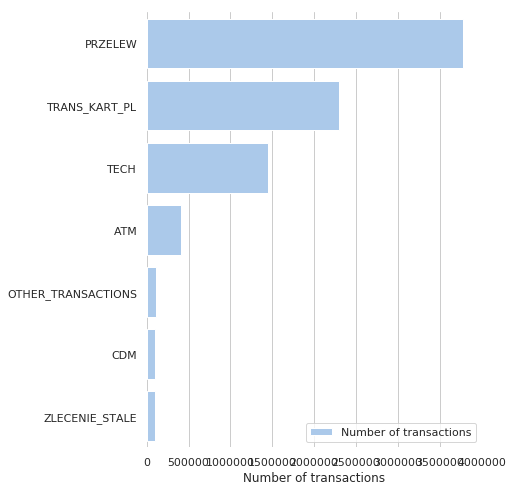

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 8))
category_counts = transactions_df.groupby(['trans_category']).count().reset_index().sort_values("credit_amt_curr", ascending=False)[:7]
sns.set_color_codes("pastel")
sns.barplot(x="credit_amt_curr", y="trans_category", data=category_counts,
            label="Number of transactions", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 4000000), ylabel="",
       xlabel="Number of transactions")
sns.despine(left=True, bottom=True)

In [ ]:
clients_df.head()

,cst_id,is_individual_flag,main_id,city,region
0,17704817,1,7011241656,Olkusz,Dolnośląskie
1,99938931,0,9405761205,Sochaczew,Pomorskie
2,11888283,1,9568764675,Rybnik,Świętokrzyskie
3,26360985,0,6832554934,Żyrardów,Wielkopolskie
4,20297326,1,2895671085,Elbląg,Lubuskie


In [ ]:
clients_df[clients_df['city'] == 'Warszawa'].head(n=10)

,cst_id,is_individual_flag,main_id,city,region
536,13095331,1,1654229967,Warszawa,Opolskie
627,60639192,0,6862679632,Warszawa,Podkarpackie
747,26384634,1,6935561008,Warszawa,Kujawsko - pomorskie
1003,91451216,1,3007663211,Warszawa,Świętokrzyskie
1192,64889479,0,9154008544,Warszawa,Małopolskie
1306,71197113,1,7824337813,Warszawa,Lubuskie
1363,89182004,1,6694436133,Warszawa,Podlaskie
1432,94245344,1,6380411126,Warszawa,Mazowieckie
1470,61667586,1,6346671245,Warszawa,Podkarpackie
1687,33939436,1,4481945343,Warszawa,Śląskie


In [ ]:
clients_df.groupby(['is_individual_flag']).count()

,cst_id,main_id,city,region
is_individual_flag,,,,
0,1921,1921,1921,1921
1,15816,15816,15816,15816


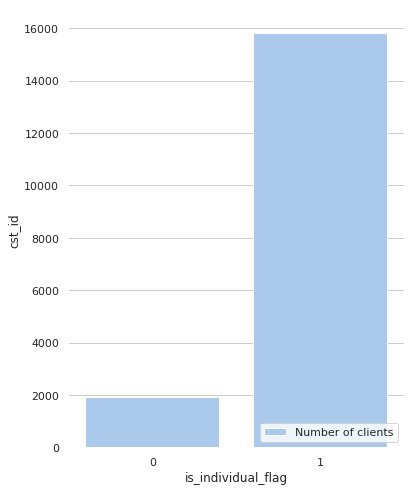

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 8))
category_counts = clients_df.groupby(['is_individual_flag']).count().reset_index()
sns.set_color_codes("pastel")
sns.barplot(x="is_individual_flag", y="cst_id", data=category_counts,
            label="Number of clients", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 4000), ylabel="",
#        xlabel="Number of clients")
sns.despine(left=True, bottom=True)

In [ ]:
clients_test_df.head(n=3)

,cst_id,main_id,city,region
0,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie
1,78259060,8425460471,Łomża,Kujawsko - pomorskie
2,17162298,7588755179,Lublin,Opolskie


In [ ]:
clients_df.groupby(['region']).count()

,cst_id,is_individual_flag,main_id,city
region,,,,
Dolnośląskie,1139,1139,1139,1139
Kujawsko - pomorskie,1104,1104,1104,1104
Lubelskie,1150,1150,1150,1150
Lubuskie,1094,1094,1094,1094
Mazowieckie,1093,1093,1093,1093
Małopolskie,1113,1113,1113,1113
Opolskie,1144,1144,1144,1144
Podkarpackie,1089,1089,1089,1089
Podlaskie,1090,1090,1090,1090


In [ ]:
clients_test_df.groupby(['region']).count()

,cst_id,main_id,city
region,,,
Dolnośląskie,4,4,4
Kujawsko - pomorskie,4,4,4
Lubelskie,4,4,4
Lubuskie,6,6,6
Mazowieckie,6,6,6
Małopolskie,5,5,5
Opolskie,10,10,10
Podkarpackie,11,11,11
Podlaskie,7,7,7


In [ ]:
transaction_types_df.head(n=10)

,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
0,0,1,UZNANIE,NONCASH
1,1,2,OTHER_TRANSACTIONS,NONCASH
2,2,3,TECH,NONCASH
3,3,4,OTHER_TRANSACTIONS,NONCASH
4,4,5,FEE,NONCASH
5,5,6,OTHER_TRANSACTIONS,NONCASH
6,6,7,OTHER_TRANSACTIONS,NONCASH
7,7,8,OTHER_TRANSACTIONS,NONCASH
8,8,9,UZNANIE,NONCASH
9,9,10,UZNANIE,NONCASH


In [ ]:
currencies_df.head(n=3)

,pk_curr_id,curr_name,sk_curr_code
0,1,United Arab Emirates Dirham,AED
1,3,Netherlands Antillian Guilder,ANG
2,4,SZYLING AUSTRIACKI,ATS


In [ ]:
transactions_df.head()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
0,57.07,95.0,57.07,95.0,129.0,2018-02-08,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH
1,33.10,95.0,33.10,95.0,129.0,2018-02-08,16178178.0,-1.0,194,129,TRANS_KART_PL,NONCASH
2,11.12,95.0,11.12,95.0,129.0,2018-02-08,74739022.0,-1.0,194,129,TRANS_KART_PL,NONCASH
3,48.35,95.0,48.35,95.0,129.0,2018-02-08,31078686.0,-1.0,194,129,TRANS_KART_PL,NONCASH
4,102.78,95.0,102.78,95.0,129.0,2018-02-08,28909100.0,-1.0,194,129,TRANS_KART_PL,NONCASH


In [ ]:
transactions_df[transactions_df['credit_cst_id'] == transactions_df['debit_cst_id']]

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
4868188,6033.26,95.0,6033.26,95.0,668.0,2017-06-13,39205013.0,39205013.0,388,668,PRZELEW,NONCASH
4871414,5008.23,95.0,5008.23,95.0,668.0,2017-11-21,39205013.0,39205013.0,388,668,PRZELEW,NONCASH
4888288,1033.26,95.0,1033.26,95.0,668.0,2017-11-27,15870890.0,15870890.0,388,668,PRZELEW,NONCASH
4891654,13154.61,95.0,13154.61,95.0,668.0,2018-02-13,77591408.0,77591408.0,388,668,PRZELEW,NONCASH
4908539,484.67,95.0,484.67,95.0,668.0,2017-08-24,30047304.0,30047304.0,388,668,PRZELEW,NONCASH
...,...,...,...,...,...,...,...,...,...,...,...,...
8572270,2114.74,95.0,2114.74,95.0,274.0,2017-07-31,13182052.0,13182052.0,114,274,TECH,NONCASH
8572271,194.11,95.0,194.11,95.0,274.0,2017-06-08,26936970.0,26936970.0,114,274,TECH,NONCASH
8572272,384.29,95.0,384.29,95.0,274.0,2017-10-16,37520632.0,37520632.0,114,274,TECH,NONCASH
8572336,2519.94,122.0,2519.94,122.0,1793.0,2017-10-17,91784617.0,91784617.0,506,1793,TECH,NONCASH


In [ ]:
transactions_df.describe()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id
count,8.572415e+06,8.572415e+06,8.572415e+06,8.572415e+06,8.572415e+06,8.572415e+06,8.572415e+06,8.572415e+06,8.572415e+06
mean,2.056195e+04,9.461962e+01,2.054378e+04,9.427720e+01,9.661056e+02,3.285011e+07,2.002851e+07,4.927953e+02,9.661056e+02
std,1.067094e+06,5.303525e+00,1.067092e+06,6.848798e+00,1.164259e+03,3.331976e+07,2.680250e+07,2.785212e+02,1.164259e+03
min,0.000000e+00,2.100000e+01,-6.231100e+02,2.100000e+01,6.000000e+00,-1.000000e+00,-1.000000e+00,5.000000e+00,6.000000e+00
25%,2.278000e+01,9.500000e+01,2.221000e+01,9.500000e+01,1.290000e+02,-1.000000e+00,-1.000000e+00,1.940000e+02,1.290000e+02
50%,1.146800e+02,9.500000e+01,1.119100e+02,9.500000e+01,4.500000e+02,2.577738e+07,-1.000000e+00,5.020000e+02,4.500000e+02
75%,9.070600e+02,9.500000e+01,8.945700e+02,9.500000e+01,7.890000e+02,6.172067e+07,3.554815e+07,6.140000e+02,7.890000e+02
max,2.071611e+08,1.850000e+02,2.071611e+08,1.850000e+02,6.101000e+03,9.999597e+07,9.999597e+07,1.402000e+03,6.101000e+03


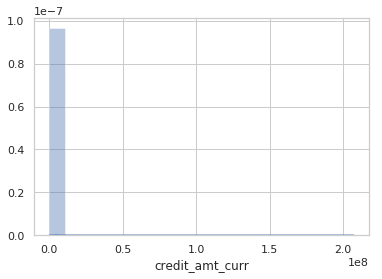

In [ ]:
sns.distplot(transactions_df['credit_amt_curr'], bins=20);

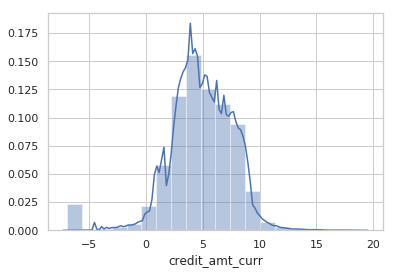

In [ ]:
sns.distplot(np.log(np.clip(transactions_df['credit_amt_curr'], 0, None) + 0.001), bins=20);

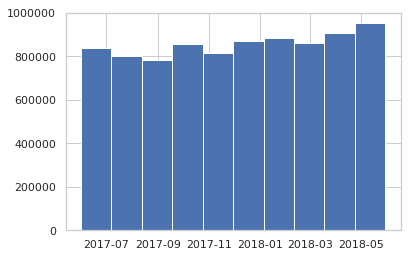

In [ ]:
plt.hist(transactions_df['date'])
plt.show()

In [ ]:
print(min(transactions_df['date']))
print(max(transactions_df['date']))

2017-06-01 00:00:00
2018-05-30 00:00:00


In [ ]:
print(len(transactions_df[transactions_df['debit_cst_id'] != -1]))
print(len(transactions_df[transactions_df['credit_cst_id'] != -1]))
print(len(transactions_df[(transactions_df['credit_cst_id'] != -1) & (transactions_df['debit_cst_id'] != -1)]))
print(len(transactions_df[(transactions_df['credit_cst_id'] == -1) & (transactions_df['debit_cst_id'] == -1)]))
print(len(transactions_df[(transactions_df['credit_cst_id'] == -1) & (transactions_df['debit_cst_id'] != -1)]))
print(len(transactions_df[(transactions_df['credit_cst_id'] != -1) & (transactions_df['debit_cst_id'] == -1)]))


5162865
4043893
634343
0
4528522
3409550


In [ ]:
print(len(transactions_df[(transactions_df['credit_cst_id'] != transactions_df['debit_cst_id'])
                          & (transactions_df['credit_cst_id'] != -1)
                          & (transactions_df['debit_cst_id'] != -1)]))

1905


In [ ]:
transactions_df[(transactions_df['credit_cst_id'] != transactions_df['debit_cst_id'])
                          & (transactions_df['credit_cst_id'] != -1)
                          & (transactions_df['debit_cst_id'] != -1)]

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
4865250,2518.01,95.0,2518.01,95.0,668.0,2018-02-08,21443441.0,92459923.0,388,668,PRZELEW,NONCASH
4865518,21209.22,95.0,21209.22,95.0,668.0,2018-02-08,80325914.0,46584985.0,388,668,PRZELEW,NONCASH
4866202,2409.49,95.0,2409.49,95.0,668.0,2018-02-08,21443441.0,95227769.0,388,668,PRZELEW,NONCASH
4866753,2250.18,95.0,2250.18,95.0,668.0,2018-02-08,21443441.0,68308744.0,388,668,PRZELEW,NONCASH
4866913,2431.21,95.0,2431.21,95.0,668.0,2018-02-08,21443441.0,26612577.0,388,668,PRZELEW,NONCASH
...,...,...,...,...,...,...,...,...,...,...,...,...
8332660,4675.15,95.0,4675.15,95.0,634.0,2017-12-13,34583504.0,14730298.0,976,634,TECH,NONCASH
8335262,49.26,95.0,11.25,38.0,1896.0,2018-05-21,53201843.0,71603261.0,625,1896,ATM,CASH
8335399,999.68,95.0,244.57,38.0,1896.0,2018-04-28,55353556.0,76470846.0,625,1896,ATM,CASH
8335479,999.68,95.0,245.06,38.0,1896.0,2017-11-29,55353556.0,76470846.0,625,1896,ATM,CASH


In [ ]:
len(clients_df['cst_id'].unique())

17737

In [ ]:
len(clients_df['main_id'].unique())

17737

In [ ]:
clients_df.groupby(['region']).count()

,cst_id,is_individual_flag,main_id,city
region,,,,
Dolnośląskie,1139,1139,1139,1139
Kujawsko - pomorskie,1104,1104,1104,1104
Lubelskie,1150,1150,1150,1150
Lubuskie,1094,1094,1094,1094
Mazowieckie,1093,1093,1093,1093
Małopolskie,1113,1113,1113,1113
Opolskie,1144,1144,1144,1144
Podkarpackie,1089,1089,1089,1089
Podlaskie,1090,1090,1090,1090


In [ ]:
clients_df.groupby(['city']).count().sort_values('cst_id')

,cst_id,is_individual_flag,main_id,region
city,,,,
Szczytno,62,62,62,62
Nowa Ruda,66,66,66,66
Ostróda,68,68,68,68
Wągrowiec,71,71,71,71
Głogów,72,72,72,72
...,...,...,...,...
Radomsko,107,107,107,107
Mikołów,108,108,108,108
Kłodzko,108,108,108,108


In [ ]:
merged_debit = pd.merge(transactions_df, clients_df, how='inner', left_on='debit_cst_id', right_on='cst_id')

In [ ]:
merged_debit.head()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type,cst_id,is_individual_flag,main_id,city,region
0,57.07,95.0,57.07,95.0,129.0,2018-02-08,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH,64222014,1,3592212039,Gniezno,Świętokrzyskie
1,28.59,95.0,28.59,95.0,129.0,2018-02-08,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH,64222014,1,3592212039,Gniezno,Świętokrzyskie
2,22.52,95.0,22.52,95.0,129.0,2017-06-13,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH,64222014,1,3592212039,Gniezno,Świętokrzyskie
3,15.68,95.0,15.68,95.0,129.0,2017-06-13,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH,64222014,1,3592212039,Gniezno,Świętokrzyskie
4,15.21,95.0,15.21,95.0,129.0,2018-01-16,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH,64222014,1,3592212039,Gniezno,Świętokrzyskie


In [ ]:
len(merged_debit[merged_debit['cst_id'] == 64222014]['prod_trans_type_id'].unique())

21

In [ ]:
print(len(transactions_df[transactions_df['debit_amt_curr'] != transactions_df['credit_amt_curr']]))
print(len(transactions_df[transactions_df['debit_amt_curr'] == transactions_df['credit_amt_curr']]))

455951
8116464


In [ ]:
transactions_df[transactions_df['debit_amt_curr'] != transactions_df['credit_amt_curr']].head()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
3151669,18.91,95.0,8.67,38.0,133.0,2018-02-08,13546889.0,-1.0,198,133,TRANS_KART_ZAGR,NONCASH
3151670,4938.68,95.0,1166.22,38.0,133.0,2018-02-08,87774633.0,-1.0,198,133,TRANS_KART_ZAGR,NONCASH
3151672,181.58,95.0,68.92,38.0,133.0,2018-02-08,62695882.0,-1.0,198,133,TRANS_KART_ZAGR,NONCASH
3151677,153.81,95.0,43.23,38.0,133.0,2018-02-08,99151598.0,-1.0,198,133,TRANS_KART_ZAGR,NONCASH
3151686,204.84,95.0,57.08,38.0,133.0,2018-02-08,58219629.0,-1.0,198,133,TRANS_KART_ZAGR,NONCASH


In [ ]:
print(len(transactions_df[(transactions_df['debit_amt_curr'] != transactions_df['credit_amt_curr']) & (transactions_df['credit_cst_id'] != -1)]))
transactions_df[(transactions_df['debit_amt_curr'] != transactions_df['credit_amt_curr']) & (transactions_df['credit_cst_id'] != -1)].head()

151480


,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
3183185,233.05,38.0,1051.67,95.0,450.0,2018-02-08,-1.0,44502966.0,502,450,PRZELEW,NONCASH
3189070,115.43,38.0,499.68,95.0,450.0,2017-06-13,-1.0,80040377.0,502,450,PRZELEW,NONCASH
3196370,182.71,38.0,758.23,95.0,450.0,2018-01-16,-1.0,90450367.0,502,450,PRZELEW,NONCASH
3205750,4748.82,38.0,20650.19,95.0,450.0,2017-11-21,-1.0,68814447.0,502,450,PRZELEW,NONCASH
3207519,146.07,38.0,639.37,95.0,450.0,2017-10-26,-1.0,90701721.0,502,450,PRZELEW,NONCASH


In [ ]:
transactions_df[(transactions_df['debit_amt_curr'] > transactions_df['credit_amt_curr']) & (transactions_df['credit_cst_id'] != -1)]

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
3183185,233.05,38.0,1051.67,95.0,450.0,2018-02-08,-1.0,44502966.0,502,450,PRZELEW,NONCASH
3189070,115.43,38.0,499.68,95.0,450.0,2017-06-13,-1.0,80040377.0,502,450,PRZELEW,NONCASH
3196370,182.71,38.0,758.23,95.0,450.0,2018-01-16,-1.0,90450367.0,502,450,PRZELEW,NONCASH
3205750,4748.82,38.0,20650.19,95.0,450.0,2017-11-21,-1.0,68814447.0,502,450,PRZELEW,NONCASH
3207519,146.07,38.0,639.37,95.0,450.0,2017-10-26,-1.0,90701721.0,502,450,PRZELEW,NONCASH
...,...,...,...,...,...,...,...,...,...,...,...,...
8572230,2.26,122.0,16.77,95.0,2980.0,2017-09-29,21443441.0,21443441.0,789,2980,TECH,NONCASH
8572233,4.40,38.0,18.96,95.0,2980.0,2017-09-29,59164336.0,59164336.0,789,2980,TECH,NONCASH
8572302,420.09,38.0,1834.81,95.0,440.0,2018-04-18,-1.0,26674898.0,492,440,UZNANIE,NONCASH
8572303,113.17,38.0,450.60,95.0,440.0,2017-12-14,-1.0,73373509.0,492,440,UZNANIE,NONCASH


In [ ]:
transactions_df[transactions_df['debit_cst_id'] == 64222014].sort_values(by=['date'])

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
8315368,110.31,95.0,110.31,95.0,4989.0,2017-06-02,64222014.0,-1.0,1306,4989,ATM,CASH
516729,17.34,95.0,17.34,95.0,129.0,2017-06-02,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH
5490647,2008.23,95.0,2008.23,95.0,716.0,2017-06-03,64222014.0,64222014.0,398,716,PRZELEW,NONCASH
5490637,969.68,95.0,969.68,95.0,716.0,2017-06-03,64222014.0,-1.0,398,716,PRZELEW,NONCASH
600222,41.65,95.0,41.65,95.0,129.0,2017-06-03,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH
...,...,...,...,...,...,...,...,...,...,...,...,...
27357,35.21,95.0,35.21,95.0,129.0,2018-05-29,64222014.0,-1.0,194,129,TRANS_KART_PL,NONCASH
2654469,933.24,95.0,933.24,95.0,499.0,2018-05-30,64222014.0,-1.0,840,499,PRZELEW,NONCASH
2654623,423.24,95.0,423.24,95.0,499.0,2018-05-30,64222014.0,-1.0,840,499,PRZELEW,NONCASH
8488927,0.00,95.0,1.83,95.0,3073.0,2018-05-30,64222014.0,-1.0,808,3073,TECH,NONCASH


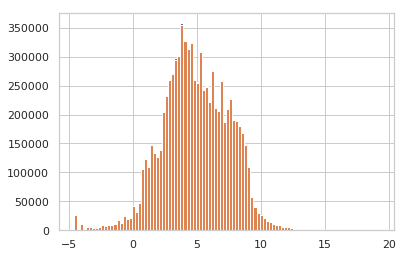

In [ ]:
plt.hist(np.log(transactions_df[transactions_df['credit_amt_curr'] > 0]['credit_amt_curr'].values),bins=100)
plt.hist(np.log(transactions_df[transactions_df['debit_amt_curr'] > 0]['debit_amt_curr'].values),bins=100)
plt.show()

In [ ]:
np.max(transactions_df['credit_amt_curr'].values)

207161076.12

In [ ]:
transactions_df[transactions_df['debit_amt_curr'] == 0]

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
5828013,1.50,95.0,0.0,95.0,382.0,2017-10-02,-1.0,21443441.0,309,382,WPLATA-ODDZIAL,CASH
7478618,0.16,95.0,0.0,95.0,387.0,2017-09-27,-1.0,21443441.0,314,387,WPLATA-ODDZIAL,CASH
7479228,0.50,95.0,0.0,95.0,387.0,2018-01-29,-1.0,21443441.0,314,387,WPLATA-ODDZIAL,CASH
7481536,0.45,95.0,0.0,95.0,387.0,2017-06-12,-1.0,21443441.0,314,387,WPLATA-ODDZIAL,CASH
7485894,2.00,95.0,0.0,95.0,980.0,2018-01-16,-1.0,24434311.0,412,980,WPLATA-ODDZIAL,CASH
...,...,...,...,...,...,...,...,...,...,...,...,...
8572385,0.14,95.0,0.0,95.0,3034.0,2018-01-02,-1.0,35236645.0,800,3034,WPLATA-ODDZIAL,CASH
8572386,0.01,95.0,0.0,95.0,3034.0,2018-01-02,-1.0,48752075.0,800,3034,WPLATA-ODDZIAL,CASH
8572390,0.01,95.0,0.0,95.0,3034.0,2018-01-02,-1.0,23604328.0,800,3034,WPLATA-ODDZIAL,CASH
8572391,0.01,95.0,0.0,95.0,3034.0,2018-01-02,-1.0,46722528.0,800,3034,WPLATA-ODDZIAL,CASH


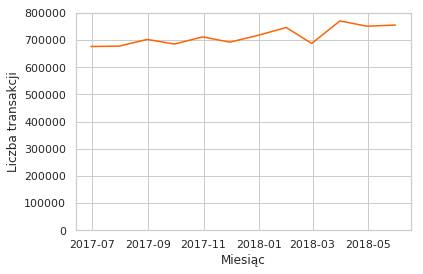

In [ ]:
plt.plot(transactions_df.groupby(pd.Grouper(key='date', freq='M'))['credit_amt_curr'].count(), color=(255/255,98/255,0/255, 1))
plt.ylim(bottom=0, top=800000)
plt.xlabel('Miesiąc')
plt.ylabel('Liczba transakcji')
plt.show()

In [ ]:
transactions_df.groupby(pd.Grouper(key='date', freq='M')).count()[['credit_amt_curr']]

,credit_amt_curr
date,
2017-06-30,676280
2017-07-31,677531
2017-08-31,702322
2017-09-30,685209
2017-10-31,711602
2017-11-30,692262
2017-12-31,717383
2018-01-31,746103
2018-02-28,687461


In [ ]:
clients_ind = clients_df[['cst_id', 'is_individual_flag']]
merged_debit = pd.merge(transactions_df, clients_ind, how='inner', left_on='debit_cst_id', right_on='cst_id')
merged_credit = pd.merge(merged_debit, clients_ind, how='inner', left_on='credit_cst_id', right_on='cst_id', suffixes=['_debit', '_credit'])
merged_credit['debit_individual'] = merged_credit.is_individual_flag_debit
merged_credit['credit_individual'] = merged_credit.is_individual_flag_credit
merged = merged_credit.drop(['cst_id_debit', 'cst_id_credit', 'is_individual_flag_debit', 'is_individual_flag_credit'], axis=1)

In [ ]:
merged.describe()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,debit_cst_id,credit_cst_id,Unnamed: 0,pk_prod_trans_type_id,debit_individual,credit_individual
count,6.317440e+05,631744.000000,6.317440e+05,631744.000000,631744.000000,6.317440e+05,6.317440e+05,631744.000000,631744.000000,631744.000000,631744.000000
mean,8.144723e+04,94.724543,8.141458e+04,94.549064,2484.677789,5.456100e+07,5.456584e+07,808.111624,2484.677789,0.938144,0.938116
std,2.035957e+06,4.224103,2.035943e+06,5.121462,1389.663580,2.552632e+07,2.552860e+07,324.490697,1389.663580,0.240894,0.240945
min,0.000000e+00,22.000000,-6.231100e+02,22.000000,44.000000,1.001220e+07,1.001220e+07,43.000000,44.000000,0.000000,0.000000
25%,2.020000e+00,95.000000,2.030000e+00,95.000000,716.000000,3.301783e+07,3.307292e+07,398.000000,716.000000,1.000000,1.000000
50%,5.000000e+00,95.000000,5.000000e+00,95.000000,3533.000000,5.372239e+07,5.372239e+07,1059.000000,3533.000000,1.000000,1.000000
75%,1.996800e+02,95.000000,1.996800e+02,95.000000,3533.000000,7.719845e+07,7.719845e+07,1059.000000,3533.000000,1.000000,1.000000
max,2.071611e+08,122.000000,2.071611e+08,122.000000,5363.000000,9.999597e+07,9.999597e+07,1333.000000,5363.000000,1.000000,1.000000


In [ ]:
merged.groupby(['prod_trans_type_id']).agg(
    count=('debit_individual', 'count'),    
    deb_ind_percent=('debit_individual', 'mean'),
    cred_ind_percent=('credit_individual', 'mean'),
).sort_values(by=['deb_ind_percent'])

,count,deb_ind_percent,cred_ind_percent
prod_trans_type_id,,,
4177.0,392,0.000000,0.000000
1797.0,8,0.000000,0.000000
659.0,326,0.000000,0.000000
413.0,315,0.000000,0.546032
358.0,267,0.000000,0.000000
663.0,10250,0.000000,0.000000
317.0,106,0.000000,0.000000
309.0,251,0.000000,0.000000
308.0,251,0.000000,0.000000


In [ ]:
# merged.groupby(['prod_trans_type_id', 'debit_cst_id']).agg(
#     count=('debit_individual', 'count')
# ).reset_index().sort_values(by=['count'])

In [ ]:
merged.pivot_table(values='debit_individual', index='debit_cst_id', columns='prod_trans_type_id', aggfunc='count', fill_value=0, dropna=False).reset_index()

prod_trans_type_id,debit_cst_id,44.0,45.0,46.0,66.0,76.0,77.0,82.0,201.0,274.0,275.0,308.0,309.0,317.0,318.0,358.0,413.0,465.0,468.0,498.0,501.0,521.0,634.0,642.0,658.0,659.0,663.0,668.0,696.0,716.0,792.0,1039.0,1447.0,1448.0,1792.0,1793.0,1795.0,1797.0,1896.0,1897.0,1898.0,2183.0,2493.0,2833.0,2840.0,2976.0,2980.0,2982.0,2993.0,2996.0,2997.0,3513.0,3533.0,4177.0,4240.0,4635.0,4758.0,5175.0,5363.0
0,10012205.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10017403.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10019737.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,91,0,0,0,0,0,0
3,10028928.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,10041491.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9236,99965887.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9237,99971760.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,516,0,0,0,0,0,0
9238,99972088.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9239,99993989.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
clients_df.groupby(['city']).agg({'is_individual_flag': ['count', 'sum', 'mean']}).reset_index().sort_values(by=('is_individual_flag', 'mean'))

city is_individual_flag              
                                      count sum      mean
170            Wągrowiec                 71  54  0.760563
50              Jaworzno                 83  65  0.783133
133              Siedlce                 83  66  0.795181
131           Sandomierz                 81  65  0.802469
40   Grodzisk Mazowiecki                 77  62  0.805195
..                   ...                ...  ..       ...
104               Otwock                 83  80  0.963855
89             Nowa Ruda                 66  64  0.969697
7        Bielsk Podlaski                 73  71  0.972603
54                Kielce                 88  86  0.977273
85      Mińsk Mazowiecki                 80  79  0.987500

[200 rows x 4 columns]

In [ ]:
clients_df.groupby(['region']).agg({'is_individual_flag': ['count', 'sum', 'mean']}).reset_index().sort_values(by=('is_individual_flag', 'mean'))

region is_individual_flag                
                                       count   sum      mean
0            Dolnośląskie               1139  1001  0.878841
8               Podlaskie               1090   960  0.880734
2               Lubelskie               1150  1014  0.881739
7            Podkarpackie               1089   962  0.883379
10  Warmińsko - mazurskie               1131  1002  0.885942
12     Zachodniopomorskie               1078   957  0.887755
6                Opolskie               1144  1017  0.888986
9               Pomorskie               1039   925  0.890279
15         Świętokrzyskie               1136  1015  0.893486
11          Wielkopolskie               1068   957  0.896067
13                Łódzkie               1155  1036  0.896970
3                Lubuskie               1094   983  0.898537
5             Małopolskie               1113  1001  0.899371
1    Kujawsko - pomorskie               1104   993  0.899457
4             Mazowieckie               1093   985  0.901189
14                Śląskie               1114  1008  0.904847

In [ ]:
clients_df[clients_df['city'].isin({'Warszawa', 'Wrocław', 'Poznań'})].groupby(['region', 'city']).count()[['cst_id']].pivot_table(index='city', values='cst_id', aggfunc='sum', columns='region', fill_value=0, dropna=False).reset_index()

region,city,Dolnośląskie,Kujawsko - pomorskie,Lubelskie,Lubuskie,Mazowieckie,Małopolskie,Opolskie,Podkarpackie,Podlaskie,Pomorskie,Warmińsko - mazurskie,Wielkopolskie,Zachodniopomorskie,Łódzkie,Śląskie,Świętokrzyskie
0,Poznań,9,4,0,4,10,4,2,8,5,2,2,5,1,5,9,9
1,Warszawa,8,6,4,4,5,3,6,4,4,5,6,6,6,3,4,8
2,Wrocław,7,9,13,3,2,3,5,9,6,6,8,7,4,5,9,3


In [ ]:
transaction_types_df.groupby('trans_type').groups

{'CASH': Int64Index([  14,   16,   17,   18,   35,   83,   84,   85,   87,   89,
             ...
             1335, 1336, 1372, 1373, 1381, 1510, 1511, 1512, 1513, 1515],
            dtype='int64', length=256),
 'NONCASH': Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1503, 1504, 1505, 1506, 1507, 1508, 1509, 1514, 1516, 1517],
            dtype='int64', length=1262)}

# Features

In [ ]:
def make_debit_features(clients_df, transactions_df, log=True):
  debit_features = transactions_df.groupby(['debit_cst_id']).agg(
        debit_trans_count=('debit_amt_curr', 'count'),
        debit_trans_amt_avg=('debit_amt_curr', 'mean'),
        debit_trans_amt_std=('debit_amt_curr', 'std'),
        debit_trans_amt_med=('debit_amt_curr', 'median'),
        debit_curr_count=('debit_curr_id', 'nunique'),
        debit_trans_type_count=('prod_trans_type_id', 'nunique')
    ).reset_index().fillna(0)
  if log:
    eps = 0.001
    log_features = ['debit_trans_count', 'debit_trans_amt_avg', 'debit_trans_amt_std', 'debit_trans_amt_med', 'debit_curr_count', 'debit_trans_type_count']
    for feature in log_features:
      debit_features['log_' + feature] = np.log(debit_features.pop(feature)+eps)

  debit_features = debit_features.rename(columns={"debit_cst_id": "cst_id"})
  return debit_features.fillna(0)


def make_credit_features(clients_df, transactions_df, log=True):
  credit_features = transactions_df.groupby(['credit_cst_id']).agg(
        credit_trans_count=('credit_amt_curr', 'count'),
        credit_trans_amt_avg=('credit_amt_curr', 'mean'),
        credit_trans_amt_std=('credit_amt_curr', 'std'),
        credit_trans_amt_med=('credit_amt_curr', 'median'),
        credit_curr_count=('credit_curr_id', 'nunique'),
        credit_trans_type_count=('prod_trans_type_id', 'nunique')
    ).reset_index().fillna(0)
  if log:
    eps = 0.001
    log_features = ['credit_trans_count', 'credit_trans_amt_avg', 'credit_trans_amt_std', 'credit_trans_amt_med', 'credit_curr_count', 'credit_trans_type_count']
    for feature in log_features:
      credit_features['log_' + feature] = np.log(credit_features.pop(feature)+eps)

  credit_features = credit_features.rename(columns={"credit_cst_id": "cst_id"})
  return credit_features.fillna(0)


def make_city_features(clients_df):
  cities = listclients_df['city'].unique() + clients_test_df['city'].unique().values
  city_features_columns = ['cst_id'] + cities
  city_pivot = clients_df.pivot_table(values='region', index='cst_id', columns='city', aggfunc='count', fill_value=0, dropna=False).reset_index()
  city_categorical = pd.DataFrame(city_pivot.to_dict(), columns=city_features_columns)
  return city_categorical.fillna(0)


def make_region_features(clients_df):
  region_categorical = clients_df.pivot_table(values='city', index='cst_id', columns='region', aggfunc='count', fill_value=0, dropna=False).reset_index()
  return region_categorical.fillna(0)


def make_transaction_type_features(transactions_df, log=False):
  debit_trans_type_count_df = transactions_df.pivot_table(values='credit_cst_id', index='debit_cst_id', columns='prod_trans_type_id', aggfunc='count', fill_value=0, dropna=False).reset_index()
  credit_trans_type_count_df = transactions_df.pivot_table(values='debit_cst_id', index='credit_cst_id', columns='prod_trans_type_id', aggfunc='count', fill_value=0, dropna=False).reset_index()
  debit_trans_type_count_df = debit_trans_type_count_df.rename(columns={"debit_cst_id": "cst_id"})
  credit_trans_type_count_df = credit_trans_type_count_df.rename(columns={"credit_cst_id": "cst_id"})

  merged_df = debit_trans_type_count_df.merge(credit_trans_type_count_df, suffixes=['_debit', '_credit'], on='cst_id')

  if log:
    eps = 0.001
    columns = [column for column in  merged_df.columns if column != 'cst_id']
    for feature in columns:
      merged_df['log_' + feature] = np.log(merged_df.pop(feature)+eps)

  return merged_df.fillna(0)


def make_transaction_category_features(transactions_df, log=False):
  debit_trans_category_count_df = transactions_df.pivot_table(values='credit_cst_id', index='debit_cst_id', columns='trans_category', aggfunc='count', fill_value=0, dropna=False).reset_index()
  credit_trans_category_count_df = transactions_df.pivot_table(values='debit_cst_id', index='credit_cst_id', columns='trans_category', aggfunc='count', fill_value=0, dropna=False).reset_index()
  debit_trans_category_count_df = debit_trans_category_count_df.rename(columns={"debit_cst_id": "cst_id"})
  credit_trans_category_count_df = credit_trans_category_count_df.rename(columns={"credit_cst_id": "cst_id"})

  merged_df = debit_trans_category_count_df.merge(credit_trans_category_count_df, suffixes=['_debit', '_credit'], on='cst_id')

  if log:
    eps = 0.001
    columns = [column for column in  merged_df.columns if column != 'cst_id']
    for feature in columns:
      merged_df['log_' + feature] = np.log(merged_df.pop(feature)+eps)

  return merged_df.fillna(0)

In [ ]:
def make_features_for_clients(clients_df, transactions_df, include_label=True):
  if (include_label):
    new_df = clients_df[['cst_id', 'is_individual_flag']]
  else:
    new_df = clients_df[['cst_id']]
  
  feature_dfs_dict = {
      'debit': make_debit_features(clients_df, transactions_df, log=True),
      'credit': make_credit_features(clients_df, transactions_df, log=True),
      'city': make_city_features(clients_df),
      'region': make_region_features(clients_df),
      'tr_type': make_transaction_type_features(transactions_df, log=True),
      'tr_cat': make_transaction_category_features(transactions_df, log=True),
  }

  for key in feature_dfs_dict:
    print(f'{key}: shape:{feature_dfs_dict[key].shape}')

  feature_df_names = [
                   'debit',
                   'credit',
                  #  'city',
                   'region',
                   'tr_type',
                   'tr_cat',
  ]

  for feature_df_name in feature_df_names:
    new_df = new_df.merge(feature_dfs_dict[feature_df_name], how='left', on='cst_id')
  
  return new_df

In [ ]:
features = make_features_for_clients(clients_df, transactions_df)
features_task = make_features_for_clients(clients_test_df, transactions_df, include_label=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


debit: shape:(17496, 7)
credit: shape:(17299, 7)
city: shape:(17737, 201)
region: shape:(17737, 17)
tr_type: shape:(16958, 755)
tr_cat: shape:(16958, 37)
debit: shape:(17496, 7)
credit: shape:(17299, 7)
city: shape:(99, 77)
region: shape:(99, 17)
tr_type: shape:(16958, 755)
tr_cat: shape:(16958, 37)


In [ ]:
make_city_features(clients_df)

AttributeError: ignored

# Features analysis

In [ ]:
features.shape

(17737, 820)

In [ ]:
features.head()

,cst_id,is_individual_flag,log_debit_trans_count,log_debit_trans_amt_avg,log_debit_trans_amt_std,log_debit_trans_amt_med,log_debit_curr_count,log_debit_trans_type_count,log_credit_trans_count,log_credit_trans_amt_avg,log_credit_trans_amt_std,log_credit_trans_amt_med,log_credit_curr_count,log_credit_trans_type_count,Dolnośląskie,Kujawsko - pomorskie,Lubelskie,Lubuskie,Mazowieckie,Małopolskie,Opolskie,Podkarpackie,Podlaskie,Pomorskie,Warmińsko - mazurskie,Wielkopolskie,Zachodniopomorskie,Łódzkie,Śląskie,Świętokrzyskie,6.0_debit,16.0_debit,17.0_debit,18.0_debit,19.0_debit,20.0_debit,21.0_debit,22.0_debit,23.0_debit,25.0_debit,...,5591.0_credit,5653.0_credit,6099.0_credit,6101.0_credit,ATM_debit,BLIK-mobile_debit,CDM_debit,FEE_debit,OTHER_TRANSACTIONS_debit,POLEC_ZAPLAT_debit,PRZELEW_debit,PRZELEW-ODDZIAL_debit,PRZELEW_WALUTOWY_debit,TECH_debit,TRANS_KART_PL_debit,TRANS_KART_ZAGR_debit,US_debit,UZNANIE_debit,WPLATA-ODDZIAL_debit,WYPLATA-ODDZIAL_debit,ZLECENIE_STALE_debit,ZUS_debit,ATM_credit,BLIK-mobile_credit,CDM_credit,FEE_credit,OTHER_TRANSACTIONS_credit,POLEC_ZAPLAT_credit,PRZELEW_credit,PRZELEW-ODDZIAL_credit,PRZELEW_WALUTOWY_credit,TECH_credit,TRANS_KART_PL_credit,TRANS_KART_ZAGR_credit,US_credit,UZNANIE_credit,WPLATA-ODDZIAL_credit,WYPLATA-ODDZIAL_credit,ZLECENIE_STALE_credit,ZUS_credit
0,17704817,1,6.551082,4.824929,6.575809,3.816195,0.001,2.833272,5.153297,6.263690,7.453801,1.885705,0.001,1.791926,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,305.0,0.0,0.0,0.0,87.0,12.0,23.0,0.0,0.0,145.0,109.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,47.0,0.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,99938931,0,3.637612,7.495701,7.786023,7.382890,0.001,1.609638,2.944492,8.480444,8.236201,8.152527,0.001,0.001000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11888283,1,5.030444,4.512976,4.891717,3.376256,0.001,2.197336,3.713596,5.938304,6.200475,3.419070,0.001,1.791926,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53.0,25.0,0.0,0.0,0.0,0.0,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,12.0,0.0
3,26360985,0,5.170490,5.641146,5.944016,5.029464,0.001,1.946053,3.555377,7.283640,6.686609,7.294473,0.001,0.001000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,58.0,0.0,0.0,9.0,0.0,0.0,3.0,0.0,0.0,2.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20297326,1,6.255752,4.089207,4.474763,3.566458,0.001,2.197336,2.995782,7.507990,7.909874,7.299953,0.001,0.693647,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,22.0,0.0,0.0,11.0,0.0,0.0,89.0,0.0,0.0,0.0,399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
features.describe()

,cst_id,is_individual_flag,log_debit_trans_count,log_debit_trans_amt_avg,log_debit_trans_amt_std,log_debit_trans_amt_med,log_debit_curr_count,log_debit_trans_type_count,log_credit_trans_count,log_credit_trans_amt_avg,log_credit_trans_amt_std,log_credit_trans_amt_med,log_credit_curr_count,log_credit_trans_type_count,Dolnośląskie,Kujawsko - pomorskie,Lubelskie,Lubuskie,Mazowieckie,Małopolskie,Opolskie,Podkarpackie,Podlaskie,Pomorskie,Warmińsko - mazurskie,Wielkopolskie,Zachodniopomorskie,Łódzkie,Śląskie,Świętokrzyskie,6.0_debit,16.0_debit,17.0_debit,18.0_debit,19.0_debit,20.0_debit,21.0_debit,22.0_debit,23.0_debit,25.0_debit,...,5591.0_credit,5653.0_credit,6099.0_credit,6101.0_credit,ATM_debit,BLIK-mobile_debit,CDM_debit,FEE_debit,OTHER_TRANSACTIONS_debit,POLEC_ZAPLAT_debit,PRZELEW_debit,PRZELEW-ODDZIAL_debit,PRZELEW_WALUTOWY_debit,TECH_debit,TRANS_KART_PL_debit,TRANS_KART_ZAGR_debit,US_debit,UZNANIE_debit,WPLATA-ODDZIAL_debit,WYPLATA-ODDZIAL_debit,ZLECENIE_STALE_debit,ZUS_debit,ATM_credit,BLIK-mobile_credit,CDM_credit,FEE_credit,OTHER_TRANSACTIONS_credit,POLEC_ZAPLAT_credit,PRZELEW_credit,PRZELEW-ODDZIAL_credit,PRZELEW_WALUTOWY_credit,TECH_credit,TRANS_KART_PL_credit,TRANS_KART_ZAGR_credit,US_credit,UZNANIE_credit,WPLATA-ODDZIAL_credit,WYPLATA-ODDZIAL_credit,ZLECENIE_STALE_credit,ZUS_credit
count,1.773700e+04,17737.000000,17398.000000,17398.000000,17398.000000,17398.000000,17398.000000,17398.000000,17200.000000,17200.000000,17200.000000,17200.000000,17200.000000,17200.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.00000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.0,...,16861.0,16861.000000,16861.0,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.00000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,1.686100e+04,16861.000000,16861.000000,16861.000000,16861.0,16861.0,16861.0,16861.000000,16861.000000,16861.0,16861.000000,16861.0
mean,5.511507e+07,0.891695,4.560284,4.931994,5.176653,3.186829,0.076428,1.885314,3.523975,6.290139,6.048227,5.016029,0.075944,1.229446,0.064216,0.062243,0.064836,0.061679,0.061623,0.06275,0.064498,0.061397,0.061453,0.058578,0.063765,0.060213,0.060777,0.065118,0.062807,0.064047,0.001245,0.275844,0.055513,0.000059,0.149517,1.404187,0.045964,0.000059,0.149398,0.0,...,0.0,0.019631,0.0,0.004982,19.421387,1.152363,3.007947,4.508926,5.524050,0.841231,82.039559,0.118083,1.431232,38.139316,135.458692,3.453473,1.275844,0.239547,0.000712,0.863175,5.193701,1.80707,4.875927,0.021648,3.082320,0.001068,1.156990,0.088903,1.539995e+02,0.054623,0.307099,69.195421,0.0,0.0,0.0,1.797995,1.573098,0.0,3.189135,0.0
std,2.570193e+07,0.310774,1.809370,2.627380,3.999740,2.496943,0.227215,0.967019,1.401290,2.553668,3.812769,2.870684,0.227761,0.731098,0.245144,0.241603,0.246244,0.240578,0.240476,0.24252,0.245645,0.240064,0.240167,0.234840,0.244341,0.237888,0.238927,0.246741,0.242622,0.244843,0.139260,6.573239,1.090617,0.007701,2.048465,19.621620,0.970789,0.007701,2.046272,0.0,...,0.0,0.292097,0.0,0.172481,29.862479,7.040240,230.627019,13.406059,123.388131,9.920317,613.659734,0.846803,23.883701,134.562293,196.488623,26.327978,19.909034,7.396793,0.026669,3.658926,14.152004,6.42596,393.271623,0.331886,10.046776,0.054447,17.112906,11.544097,1.059332e+04,0.461616,3.070078,4590.597886,0.0,0.0,0.0,22.544920,136.464967,0.0,16.557517,0.0
min,1.001220e+07,0.000000,0.001000,-4.509860,-6.907755,-4.509860,0.001000,0.001000,0.001000,-4.509860,-6.907755,-6.907755,0.001000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
# plt.hist(features['debit_trans_count'].values / features['credit_trans_count'].values)
# plt.show()

In [ ]:
features.groupby('is_individual_flag').mean()

,cst_id,log_debit_trans_count,log_debit_trans_amt_avg,log_debit_trans_amt_std,log_debit_trans_amt_med,log_debit_curr_count,log_debit_trans_type_count,log_credit_trans_count,log_credit_trans_amt_avg,log_credit_trans_amt_std,log_credit_trans_amt_med,log_credit_curr_count,log_credit_trans_type_count,Dolnośląskie,Kujawsko - pomorskie,Lubelskie,Lubuskie,Mazowieckie,Małopolskie,Opolskie,Podkarpackie,Podlaskie,Pomorskie,Warmińsko - mazurskie,Wielkopolskie,Zachodniopomorskie,Łódzkie,Śląskie,Świętokrzyskie,6.0_debit,16.0_debit,17.0_debit,18.0_debit,19.0_debit,20.0_debit,21.0_debit,22.0_debit,23.0_debit,25.0_debit,26.0_debit,...,5591.0_credit,5653.0_credit,6099.0_credit,6101.0_credit,ATM_debit,BLIK-mobile_debit,CDM_debit,FEE_debit,OTHER_TRANSACTIONS_debit,POLEC_ZAPLAT_debit,PRZELEW_debit,PRZELEW-ODDZIAL_debit,PRZELEW_WALUTOWY_debit,TECH_debit,TRANS_KART_PL_debit,TRANS_KART_ZAGR_debit,US_debit,UZNANIE_debit,WPLATA-ODDZIAL_debit,WYPLATA-ODDZIAL_debit,ZLECENIE_STALE_debit,ZUS_debit,ATM_credit,BLIK-mobile_credit,CDM_credit,FEE_credit,OTHER_TRANSACTIONS_credit,POLEC_ZAPLAT_credit,PRZELEW_credit,PRZELEW-ODDZIAL_credit,PRZELEW_WALUTOWY_credit,TECH_credit,TRANS_KART_PL_credit,TRANS_KART_ZAGR_credit,US_credit,UZNANIE_credit,WPLATA-ODDZIAL_credit,WYPLATA-ODDZIAL_credit,ZLECENIE_STALE_credit,ZUS_credit
is_individual_flag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.438405e+07,4.778867,6.479114,6.800374,5.140193,0.086978,2.036689,3.881523,7.536840,7.332966,6.741537,0.085262,1.253139,0.071838,0.057782,0.070796,0.057782,0.056221,0.058303,0.066111,0.066111,0.067673,0.059344,0.067153,0.057782,0.062988,0.061947,0.055180,0.062988,0.009688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,...,0.0,0.005920,0.0,0.021529,15.270183,0.644241,27.296555,4.490850,15.142088,2.994080,253.448870,0.031755,7.644779,35.377287,59.062971,4.321851,9.534446,2.099031,0.0000,0.329925,4.622713,12.958019,44.248116,0.003767,5.729279,0.0000,6.852530,0.806781,1091.102799,0.051668,0.485468,362.775027,0.0,0.0,0.0,7.333692,10.920883,0.0,4.933800,0.0
1,5.520386e+07,4.533439,4.741986,4.977237,2.946929,0.075132,1.866723,3.480203,6.137515,5.890946,4.804788,0.074804,1.226546,0.063290,0.062785,0.064112,0.062152,0.062279,0.063290,0.064302,0.060824,0.060698,0.058485,0.063354,0.060508,0.060508,0.065503,0.063733,0.064176,0.000200,0.310005,0.062388,0.000067,0.168033,1.578084,0.051656,0.000067,0.1679,0.0,0.0,...,0.0,0.021329,0.0,0.002933,19.935480,1.215290,0.000000,4.511164,4.332933,0.574618,60.811904,0.128774,0.661734,38.481370,144.919683,3.345931,0.253083,0.009265,0.0008,0.929214,5.264414,0.426115,0.000000,0.023862,2.754516,0.0012,0.451643,0.000000,37.946877,0.054989,0.285010,32.837966,0.0,0.0,0.0,1.112444,0.415450,0.0,2.973072,0.0


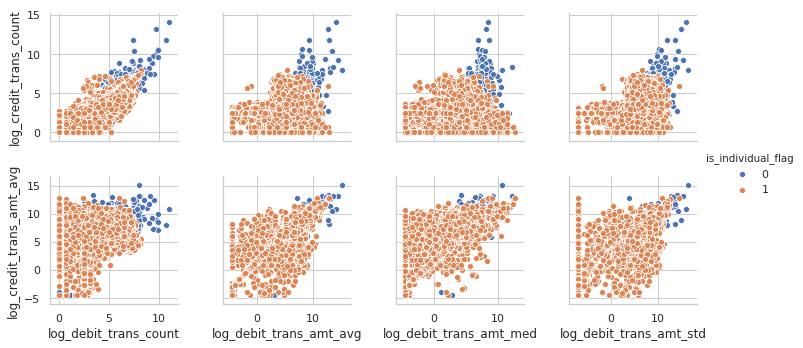

In [ ]:
sns.pairplot(features,
             hue='is_individual_flag',
             x_vars=["log_debit_trans_count", "log_debit_trans_amt_avg", 'log_debit_trans_amt_med', 'log_debit_trans_amt_std'],
             y_vars=['log_credit_trans_count', 'log_credit_trans_amt_avg'])


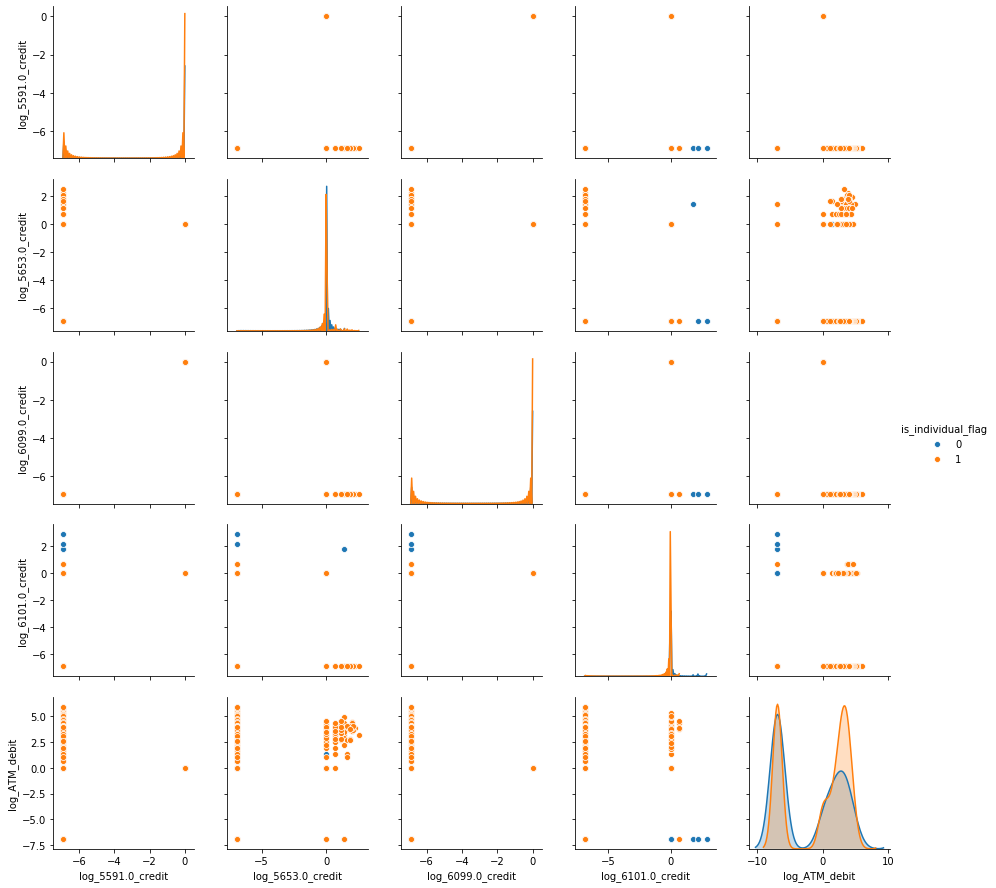

In [ ]:
idx = -40
sns.pairplot(features,
             hue='is_individual_flag',
             x_vars=features.columns[idx:idx + 5],
             y_vars=features.columns[idx:idx + 5])

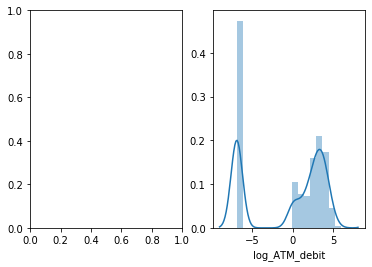

In [ ]:
# sns.FacetGrid(features.iloc[:,idx:idx + 5], col_wrap=4, height=2, ylim=(0, 10))


In [ ]:
features = features.fillna(0)

plot_shape = (5, 5)
start_index = -50
features_number = plot_shape[0] * plot_shape[1]

f, axes = plt.subplots(5, 5, figsize=[15,15])
# sns.distplot(features['log_ATM_debit'], ax=axes[1])

for idx, feature in enumerate(features.columns[start_index:start_index + features_number]):
  # print(feature)
  sns.distplot(features[features['is_individual_flag'] == 0][feature], hist=False, ax=axes[idx // plot_shape[1], idx % plot_shape[1]])
  sns.distplot(features[features['is_individual_flag'] == 1][feature], hist=False, ax=axes[idx // plot_shape[1], idx % plot_shape[1]])

# Preprocessing

In [ ]:
### removing null values
features = features.fillna(0)
features_task = features_task.fillna(0)

### labels split
X = features.drop(['cst_id', 'is_individual_flag'], axis=1).values
y = features['is_individual_flag'].values

X_task = features_task.drop(['cst_id'], axis=1).values

### inverse classes (just for testing)
# y = np.abs(y-1)

### polynomial features (don't use with many features, OOM happens even with colab's 25GB RAM)
# poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
# X = poly.fit_transform(X)

### splitting dataset in 60train/20val/20test pattern
X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

# ### only for task prediction (more training data) ----------------------------------------------------------------------------
# X_train = X
# y_train = y

### features scaling
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
# scaler = preprocessing.QuantileTransformer()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_task = scaler.transform(X_task)

X_train = np.clip(X_train, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)
X_task = np.clip(X_task, -5, 5)

In [ ]:
X_train.shape

(10642, 818)

In [ ]:
train_features = X_train
train_labels = 1 - y_train

In [ ]:
bool_train_labels = train_labels != 0

pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
pos_labels.shape

(1147,)

In [ ]:
neg_labels.shape

(9495,)

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(9495, 818)

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(9495, 818)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

In [ ]:
new_size = 200000
ids = np.arange(len(resampled_features))
choices = np.random.choice(ids, new_size)

aug_features = resampled_features[choices]
aug_labels = resampled_labels[choices]

aug_features_rand = aug_features + np.random.randn(*aug_features.shape) * 0.1

In [ ]:
aug_features

array([[-0.08,  0.83,  0.64, ...,  0.  , -0.16,  0.  ],
       [-1.26, -0.88, -0.57, ...,  0.  , -0.16,  0.  ],
       [-0.8 ,  0.62,  0.53, ...,  0.  , -0.16,  0.  ],
       ...,
       [ 0.31,  0.7 ,  0.77, ...,  0.  , -0.16,  0.  ],
       [ 0.57,  0.29,  0.51, ...,  0.  , -0.06,  0.  ],
       [-1.77,  0.78,  0.53, ...,  0.  , -0.16,  0.  ]])

In [ ]:
aug_features_rand

array([[-0.12,  0.68,  0.52, ..., -0.15, -0.3 , -0.01],
       [-1.2 , -0.79, -0.59, ...,  0.06, -0.03, -0.11],
       [-0.88,  0.67,  0.6 , ..., -0.08, -0.07,  0.01],
       ...,
       [ 0.12,  0.67,  0.78, ..., -0.03, -0.21, -0.09],
       [ 0.75,  0.29,  0.61, ...,  0.1 , -0.09, -0.01],
       [-1.77,  0.67,  0.57, ..., -0.03, -0.12,  0.11]])

In [ ]:
np.bincount(aug_labels)

array([ 99735, 100265])

In [ ]:
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(18990, 818)

In [ ]:
order = np.arange(len(aug_features_rand))
np.random.shuffle(order)
aug_features_rand = aug_features_rand[order]
aug_labels = aug_labels[order]

In [ ]:
X_train = resampled_features
y_train = 1- resampled_labels

In [ ]:
# X_train = aug_features_rand
# y_train = 1- aug_labels

# Model

## Decision tree

In [ ]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)

In [ ]:
y_val_pred_tree = clf_tree.predict(X_val)

In [ ]:
# metrics.balanced_accuracy_score(y_true, y_pred)
print(metrics.accuracy_score(y_val, y_val_pred_tree))

0.9515083168875106


In [ ]:
print(metrics.f1_score(y_val, y_val_pred_tree, average='weighted'))

0.9523897751611492


In [ ]:
print(metrics.precision_score(y_val, y_val_pred_tree, average='micro'))

0.9515083168875106


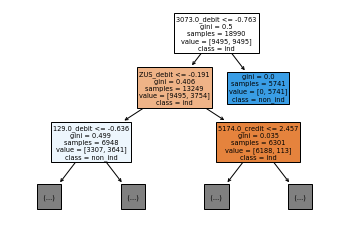

In [ ]:
feature_names = features.drop(['cst_id', 'is_individual_flag'], axis=1).columns
tree.plot_tree(clf_tree, max_depth=2, feature_names=feature_names, class_names=['ind','non_ind'], filled=True);

## SVM

In [ ]:
clf_svm = svm.SVC(gamma='scale')
clf_svm = clf_svm.fit(X_train, y_train)

In [ ]:
y_val_pred_svm = clf_svm.predict(X_val)

In [ ]:
print(metrics.f1_score(y_val, y_val_pred_svm, average='weighted'))
print(metrics.precision_score(y_val, y_val_pred_svm, average='micro'))

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# clf_rf = RandomForestClassifier(n_estimators=1000)
clf_rf = ExtraTreesClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)
clf_rf = clf_rf.fit(X_train, y_train)

In [ ]:
y_val_pred_rf = clf_rf.predict(X_val)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
clf_ab = AdaBoostClassifier(n_estimators=1000)
clf_ab.fit(X_train, y_train)

In [ ]:
y_val_pred_ab = clf_ab.predict(X_val)

## Neural network

### Function definitions

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
#     classes 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(5,5))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

METRICS = [
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      f1,
]
    

np.set_printoptions(precision=2)
# plt.rcParams["figure.figsize"] = (8,8)

### NN

In [ ]:
neg, pos = np.bincount(y_train)
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = Sequential([
      Dense(32, kernel_regularizer=regularizers.l2(0.001),
            activation='relu',
            input_shape=(X_train.shape[-1],)),
      Dropout(0.5),
      Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_recall', 
    # monitor='val_auc',
    # monitor='val_f1', 
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

initial_bias = np.log([pos/neg])
model = make_model(output_bias = initial_bias)
# model.summary()

In [ ]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight)

Train on 200000 samples, validate on 3547 samples
Epoch 1/500
200000/200000 [==============================] - 4s 20us/sample - loss: 0.4196 - recall: 0.7504 - precision: 0.8846 - auc: 0.9311 - accuracy: 0.8267 - tp: 74839.0000 - fp: 9760.0000 - tn: 90505.0000 - fn: 24896.0000 - f1: 0.8006 - val_loss: 0.2864 - val_recall: 0.9309 - val_precision: 0.9876 - val_auc: 0.9745 - val_accuracy: 0.9281 - val_tp: 2939.0000 - val_fp: 37.0000 - val_tn: 353.0000 - val_fn: 218.0000 - val_f1: 0.9587
Epoch 2/500
200000/200000 [==============================] - 1s 7us/sample - loss: 0.2398 - recall: 0.9137 - precision: 0.9204 - auc: 0.9779 - accuracy: 0.9175 - tp: 91125.0000 - fp: 7884.0000 - tn: 92381.0000 - fn: 8610.0000 - f1: 0.9170 - val_loss: 0.2244 - val_recall: 0.9332 - val_precision: 0.9896 - val_auc: 0.9783 - val_accuracy: 0.9318 - val_tp: 2946.0000 - val_fp: 31.0000 - val_tn: 359.0000 - val_fn: 211.0000 - val_f1: 0.9607
Epoch 3/500
200000/200000 [==============================] - 1s 7us/sample

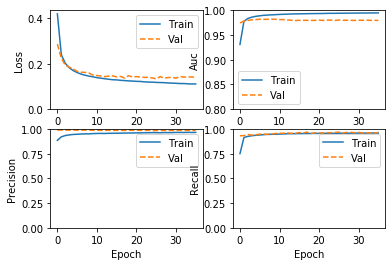

In [ ]:
plot_metrics(baseline_history)

In [ ]:
baseline_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
# baseline_results = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.14352610781200845
recall :  0.96175724
precision :  0.98510844
auc :  0.9843342
accuracy :  0.9529312
tp :  3043.0
fp :  46.0
tn :  338.0
fn :  121.0
f1 :  0.97337556



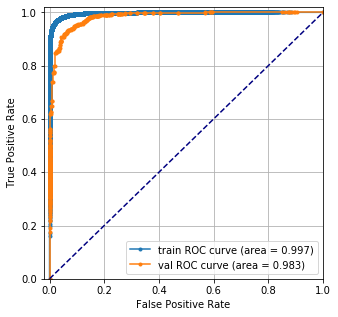

In [ ]:
y_val_pred_nn = model.predict(X_val)
y_train_pred_nn = model.predict(X_train)

val_auc = metrics.roc_auc_score(y_val, y_val_pred_nn)
train_auc = metrics.roc_auc_score(y_train, y_train_pred_nn)
train_fpr, train_tpr, _ = metrics.roc_curve(y_train, y_train_pred_nn)
val_fpr, val_tpr, _ = metrics.roc_curve(y_val, y_val_pred_nn)
plt.figure(figsize=(5,5))
plt.plot(train_fpr, train_tpr, marker='.', label='train ROC curve (area = %0.3f)' % train_auc)
plt.plot(val_fpr, val_tpr, marker='.', label='val ROC curve (area = %0.3f)' % val_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

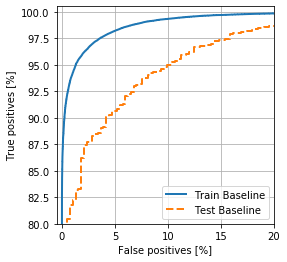

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right');

<Figure size 360x360 with 0 Axes>

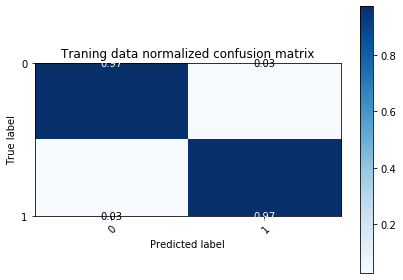

<Figure size 360x360 with 0 Axes>

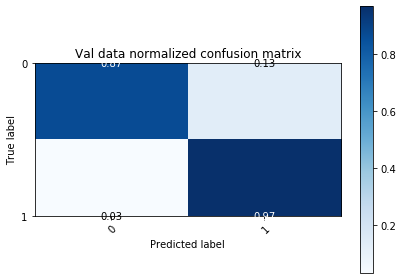

In [ ]:
p = 0.5
# Plot normalized confusion matrix
plot_confusion_matrix(y_train, (y_train_pred_nn > p).astype(int), classes=[0, 1], normalize=True,
                      title='Traning data normalized confusion matrix');

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, (y_val_pred_nn > p).astype(int), classes=[0, 1], normalize=True,
                      title='Val data normalized confusion matrix');

<Figure size 360x360 with 0 Axes>

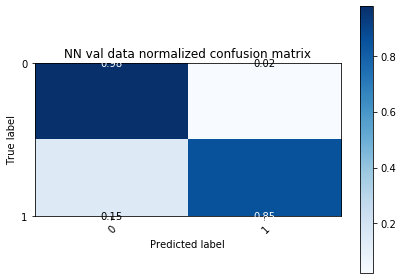

<Figure size 360x360 with 0 Axes>

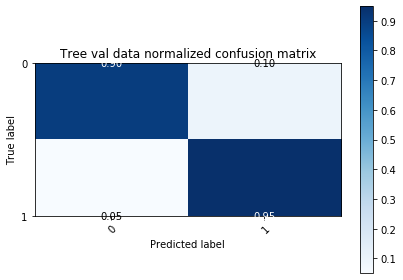

In [ ]:
p= 0.9
plot_confusion_matrix(y_val, (y_val_pred_nn > p).astype(int), classes=[0, 1], normalize=True,
                      title='NN val data normalized confusion matrix');
                      
plot_confusion_matrix(y_val, y_val_pred_tree, classes=[0, 1], normalize=True,
                      title='Tree val data normalized confusion matrix');

In [ ]:
# plt.plot(history.history['accuracy'][plot_start:])
# # plt.plot(history.history['f1'][plot_start:])
# plt.plot(history.history['precision'][plot_start:])
# plt.plot(history.history['recall'][plot_start:])

# plt.plot(history.history['val_accuracy'][plot_start:])
# # plt.plot(history.history['val_f1'][plot_start:])
# plt.plot(history.history['val_precision'][plot_start:])
# plt.plot(history.history['val_recall'][plot_start:])

# plt.ylabel('Metrics')
# plt.xlabel('Epoch')
# # plt.legend(['acc', 'f1', 'prec', 'rec', 'val_acc', 'val_f1', 'val_prec', 'val_rec'], loc='upper left')
# plt.legend(['acc', 'f1', 'val_acc', 'val_f1'], loc='lower right')
# plt.grid()
# plt.show()

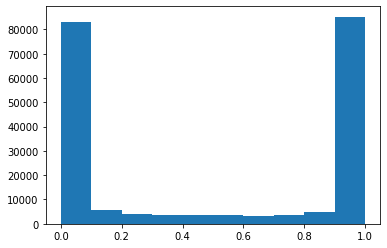

In [ ]:
plt.hist(y_train_pred_nn)
plt.show()

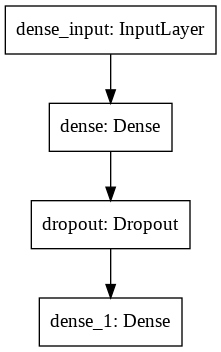

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', expand_nested=True,)

## Model comparison

In [ ]:
y_val_pred_nn

array([[0.99],
       [1.  ],
       [0.  ],
       ...,
       [0.97],
       [1.  ],
       [0.99]], dtype=float32)

In [ ]:
def print_metrics(y_true, y_pred):
  tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

  print(f'acc: {metrics.accuracy_score(y_val, y_pred)}')
  print(f'f1: {metrics.f1_score(y_val, y_pred, average="weighted")}')
  print(f'recall: {metrics.recall_score(y_val, y_pred, average="weighted")}')
  print(f'precision: {metrics.precision_score(y_val, y_pred, average="weighted")}')
  print(f'tp: {tp}')
  print(f'tn: {tn}')
  print(f'fp: {fp}')
  print(f'fn: {fn}')

models = [
          ('tree', y_val_pred_tree),
          ('svm', y_val_pred_svm),
          ('nn_0.3', y_val_pred_nn > 0.3),
          ('nn_0.5', y_val_pred_nn > 0.5),
          ('nn_0.7', y_val_pred_nn > 0.7),
          ('random_forest', y_val_pred_rf),
          ('adaboost', y_val_pred_ab),
]

def calc_metrics(model_name, y_true, y_pred):
  [tn, fp, fn, tp] = metrics.confusion_matrix(y_true, y_pred).ravel()
  acc = metrics.accuracy_score(y_val, y_pred)
  f1 = metrics.f1_score(y_val, y_pred, average="weighted")
  rec = metrics.recall_score(y_val, y_pred, average="weighted")
  prec = metrics.precision_score(y_val, y_pred, average="weighted")
  return [model_name, tp, tn, fp, fn, f1, rec, prec, acc]


def make_metric_df(y_val):
  columns = ['model', 'tp', 'tn', 'fp', 'fn', 'f1', 'rec', 'prec', 'acc']
  all_results = []
  for name, y_pred in models:
    results = calc_metrics(name, y_val, y_pred)
    all_results.append(results)
  return pd.DataFrame(all_results, columns=columns)


# for name, y_pred in models:
#   print(name)
#   print_metrics(1 - y_val, 1 - y_pred)
#   print()

make_metric_df(y_val)

,model,tp,tn,fp,fn,f1,rec,prec,acc
0,tree,3079,311,79,78,0.955712,0.955737,0.955688,0.955737
1,svm,3138,269,121,19,0.957875,0.960530,0.959701,0.960530
2,nn_0.3,3085,329,61,72,0.962732,0.962504,0.963000,0.962504
3,nn_0.5,2984,362,28,173,0.947108,0.943332,0.956171,0.943332
4,nn_0.7,2781,375,15,376,0.903862,0.889766,0.940176,0.889766
5,random_forest,3133,302,88,24,0.967171,0.968424,0.967589,0.968424
6,adaboost,3119,317,73,38,0.968057,0.968706,0.967875,0.968706


In [ ]:
a,b,c,d = metrics.confusion_matrix(y_val, y_val_pred_ab).ravel()

<Figure size 360x360 with 0 Axes>

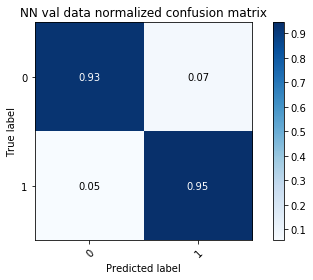

<Figure size 360x360 with 0 Axes>

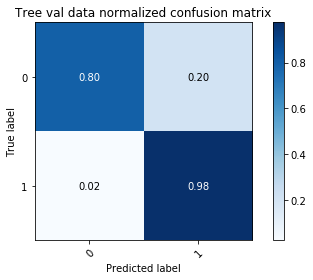

<Figure size 360x360 with 0 Axes>

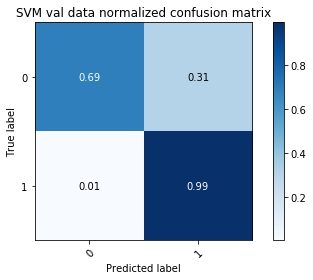

In [ ]:
p= 0.5
plot_confusion_matrix(y_val, (y_val_pred_nn > p).astype(int), classes=[0, 1], normalize=True,
                      title='NN val data normalized confusion matrix');
                      
plot_confusion_matrix(y_val, y_val_pred_tree, classes=[0, 1], normalize=True,
                      title='Tree val data normalized confusion matrix');

plot_confusion_matrix(y_val, y_val_pred_svm, classes=[0, 1], normalize=True,
                      title='SVM val data normalized confusion matrix');

# Prediction for clients_test.csv

In [ ]:
y_task_pred_ab = clf_ab.predict(X_task)

In [ ]:
y_task_pred_ab

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [ ]:
test_result_df = clients_test_df.copy()

In [ ]:
test_result_df['is_individual'] = y_task_pred_ab

In [ ]:
test_result_df = test_result_df[['cst_id', 'is_individual']]

In [ ]:
test_result_df.to_csv('results.csv', index=False)